In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from scipy.stats import invwishart
from scipy.linalg import inv

## Manifold learning procedure with bayesian technique

In [2]:
def bayes_ml(Y, Z, bandwidths_list, tau):
    
    # number of iterations
    n_iterations = len(bandwidths_list)
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    
    # pairwise distances
    dist = pairwise_distances(Y)
    
    if Z is not None:
        print('before first iteration:', np.linalg.norm(Y - Z, ord='fro')**2 / n)
    
    for k in range(n_iterations):
        
        # bandwidth
        h = bandwidths_list[k]
        
        # compute weights and sum of weights
        if (k==0):
            W = np.exp(-dist**2/h**2) * (dist < tau)
            N = np.sum(W, axis=1)
        else:
            W = np.exp(-a_dist**2 * h**2) * (dist < tau)
            N = np.sum(W, axis=1)
        
        # compute adjusted distances
        a_dist = np.empty((n, n))
        for i in range(n):
            Y_diff = Y - Y[i, :]   #(n, D)
            
            # compute the weighted sample covariance
            Sigma = np.cov(Y_diff.T, aweights=W[i])
            # sample a precision matrix from the inverse Wishart distribution

            Omega = invwishart.rvs(N[i] + D + 2, inv(h**2 * np.identity(D) + Sigma), size=1)

            Q = Y_diff @ Omega 
            a_dist[i,:] = np.linalg.norm(Q, axis = 1)
            
        # adjusted Nadaraya-Watson estimate

        X = W.dot(Y) / np.tile(N.reshape(-1, 1), (1, D))
        
        # compare with the true values
        if Z is not None:
            print('iteration', k+1, ':', np.linalg.norm(X - Z, ord='fro')**2 / n)
                
    return X

In [3]:
def not_bayes_ml(Y, Z, bandwidths_list, tau):
    
    # number of iterations
    n_iterations = len(bandwidths_list)
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    
    # pairwise distances
    dist = pairwise_distances(Y)
    
    if Z is not None:
        print('before first iteration:', np.linalg.norm(Y - Z, ord='fro')**2 / n)
    
    for k in range(n_iterations):
        
        # bandwidth
        h = bandwidths_list[k]
        
        # compute weights and sum of weights
        if (k==0):
            W = np.exp(-dist**2/h**2) * (dist < tau)
            N = np.sum(W, axis=1)
        else:
            W = np.exp(-a_dist**2 * h**2) * (dist < tau)
            N = np.sum(W, axis=1)
        
        # compute adjusted distances
        a_dist = np.empty((n, n))
        for i in range(n):
            Y_diff = Y - Y[i, :]   #(n, D)
            
            # compute the weighted sample covariance
            Sigma = np.cov(Y_diff.T, aweights=W[i])
            # sample a precision matrix from the inverse Wishart distribution

#             Omega = invwishart.rvs(N[i] + D + 2, inv(h**2 * np.identity(D) + Sigma), size=1)
            Omega = inv(h**2 * np.identity(D) + Sigma)

            Q = Y_diff @ Omega 
            a_dist[i,:] = np.linalg.norm(Q, axis = 1)
            
        # adjusted Nadaraya-Watson estimate

        X = W.dot(Y) / np.tile(N.reshape(-1, 1), (1, D))
        
        # compare with the true values
        if Z is not None:
            print('iteration', k+1, ':', np.linalg.norm(X - Z, ord='fro')**2 / n)
                
    return X

## Artificial low-dimensional examples

### S-shape

In [207]:
n_samples = 1500
noise_level = 0.6

# True values
Z, t = make_s_curve(n_samples, 0, random_state=1)

# Add noise
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [208]:
n_iterations = 19
a = 1.15
bandwidths = 0.6 * a**(-np.arange(n_iterations))
print(bandwidths)

[0.6        0.52173913 0.4536862  0.39450974 0.34305195 0.29830604
 0.25939656 0.22556222 0.19614106 0.17055745 0.14831082 0.12896593
 0.11214429 0.09751677 0.08479719 0.07373669 0.06411886 0.05575553
 0.04848307]


In [210]:
# %%time
X = bayes_ml(Y, Z, bandwidths, tau=0.9)

before first iteration: 0.0911267310529447
iteration 1 : 0.06707652796570558
iteration 2 : 0.08535411034256837
iteration 3 : 0.08536236361093899
iteration 4 : 0.08536213228315237
iteration 5 : 0.08536190947387644
iteration 6 : 0.08536171300488515
iteration 7 : 0.08536165765804564
iteration 8 : 0.08536154853006753
iteration 9 : 0.08536159101865727
iteration 10 : 0.08536162633836275
iteration 11 : 0.08536167434030102
iteration 12 : 0.08536200852911925
iteration 13 : 0.08536225919288215
iteration 14 : 0.0853625179427288
iteration 15 : 0.08536262740009526
iteration 16 : 0.08536287610916944
iteration 17 : 0.08536304184488192
iteration 18 : 0.08536318078961634
iteration 19 : 0.0853633278778007


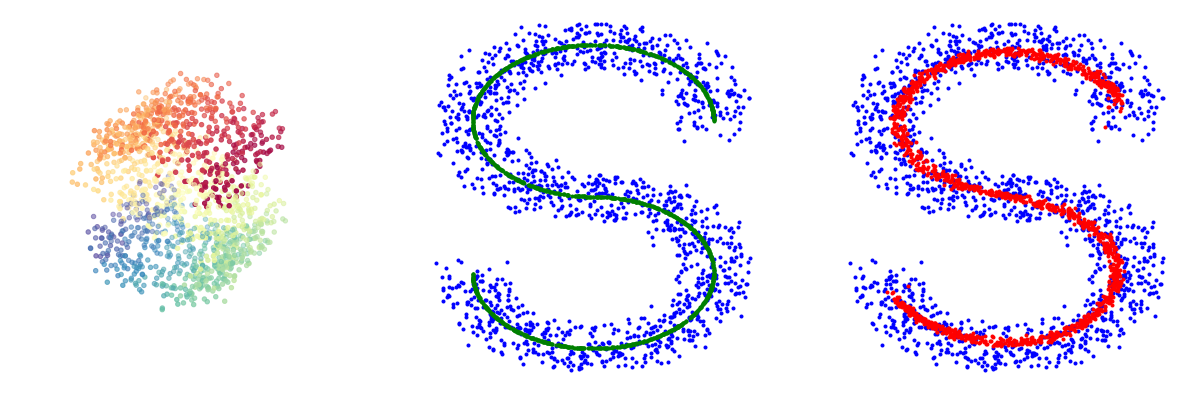

In [211]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

### Swiss Roll

In [212]:
n_samples = 1500
noise_level = 2.5

# True values
Z, t = make_swiss_roll(n_samples, 0, random_state=1)

# Add noise
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [213]:
n_iterations = 10
a = 1.1
bandwidths = 2.5 * a**(-np.arange(n_iterations))
print(bandwidths)

[2.5        2.27272727 2.0661157  1.878287   1.70753364 1.55230331
 1.41118483 1.2828953  1.16626845 1.06024405]


In [214]:
X = bayes_ml(Y, Z, bandwidths, tau=4.0)

before first iteration: 1.5403586560350766
iteration 1 : 1.2224108083916543
iteration 2 : 1.4523538078417269
iteration 3 : 1.4563485007509782
iteration 4 : 1.4561224199468268
iteration 5 : 1.4561709130651097
iteration 6 : 1.456379846053293
iteration 7 : 1.4560779397710022
iteration 8 : 1.4562598994774492
iteration 9 : 1.4561658449718582
iteration 10 : 1.4560883856183233


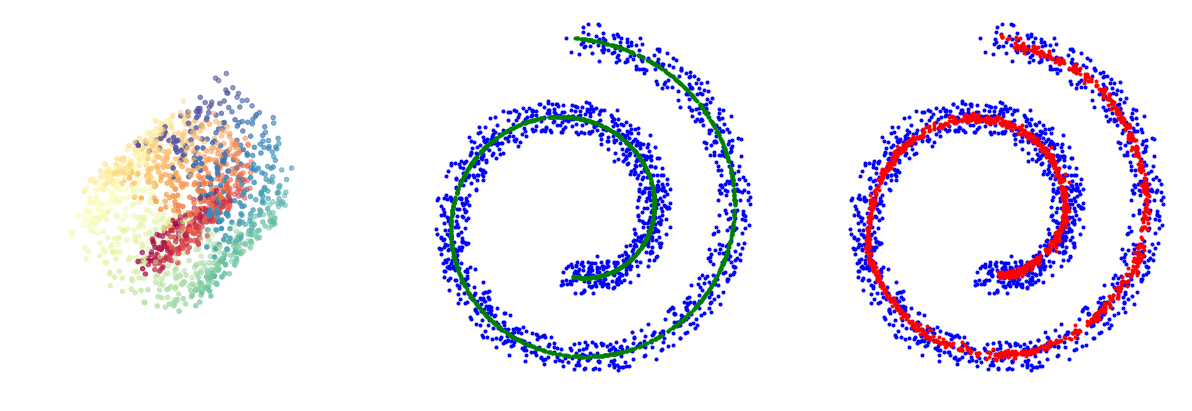

In [215]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

### Sphere

In [3]:
n_samples = 1500
total_dim = 3
manifold_dim = 2
noise_level = 0.2

# True values
Z = np.zeros((n_samples, total_dim))
# Z[:,0] = np.random.uniform(-1, 1, (n_samples))
Z[:, :manifold_dim] = np.random.normal(size=(n_samples, manifold_dim))
Z[:, :manifold_dim] /= np.linalg.norm(Z, axis = 1, keepdims=True)

# Add noise
eps = rand(n_samples, total_dim) - 0.5
Y = Z + noise_level * eps

In [4]:
n_iterations = 10
a = 1.1
bandwidths = 0.3 * a**(-np.arange(n_iterations))
print(bandwidths)

[0.3        0.27272727 0.24793388 0.22539444 0.20490404 0.1862764
 0.16934218 0.15394744 0.13995221 0.12722929]


In [5]:
X = bayes_ml(Y, Z, bandwidths, tau=0.4)

before first iteration: 0.00997970087370191
iteration 1 : 0.0037781045471438172
iteration 2 : 0.0042034310485642235
iteration 3 : 0.004203454473571329
iteration 4 : 0.0042034542483800705
iteration 5 : 0.0042034526165293015
iteration 6 : 0.004203451018062038
iteration 7 : 0.004203450375576412
iteration 8 : 0.004203451325930498
iteration 9 : 0.004203450335489984
iteration 10 : 0.0042034533510451645


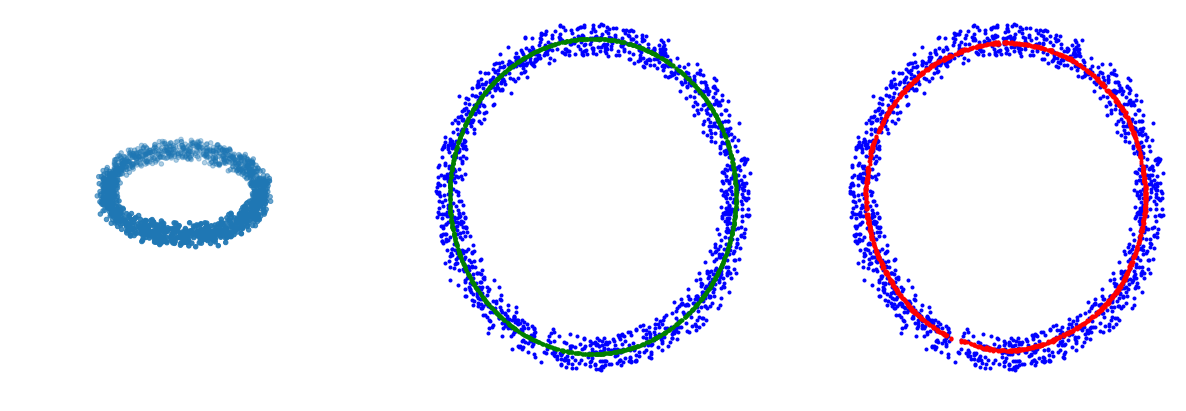

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], cmap=plt.cm.Spectral, label='Noisy observations')
ax.set_zlim(-1,1)
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 1], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 1], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

In [9]:
X = not_bayes_ml(Y, Z, bandwidths, tau=0.4)

before first iteration: 0.00997970087370191
iteration 1 : 0.0037781045471438172
iteration 2 : 0.003952094992824709
iteration 3 : 0.003968400406492925
iteration 4 : 0.003967398630298308
iteration 5 : 0.003970187335727597
iteration 6 : 0.003980753302562762
iteration 7 : 0.004001077566382588
iteration 8 : 0.004032750125011771
iteration 9 : 0.00407702531785482
iteration 10 : 0.004134677242305933


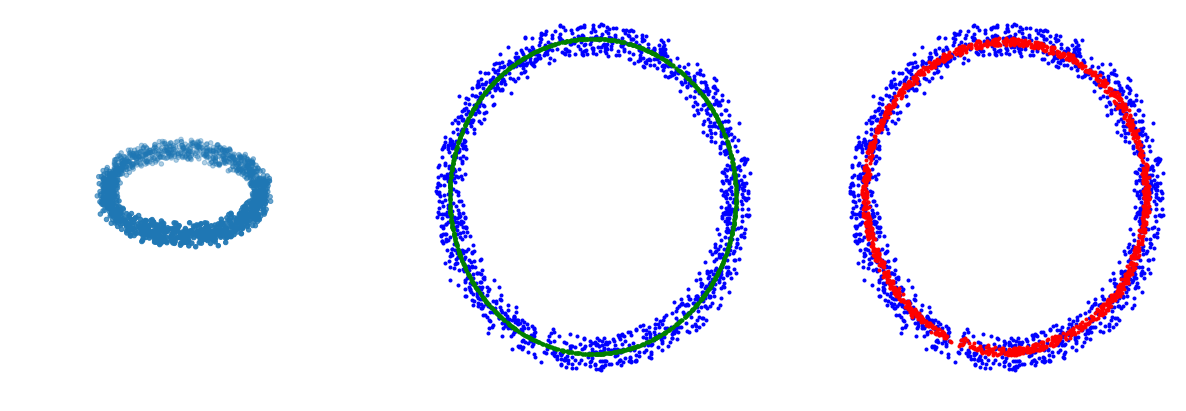

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], cmap=plt.cm.Spectral, label='Noisy observations')
ax.set_zlim(-1,1)
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 1], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 1], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

## reconstruction

In [95]:
image = image / 256.

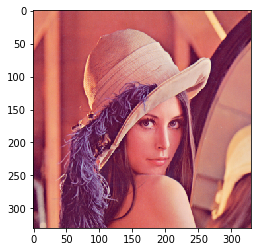

In [96]:
plt.imshow(image)

In [100]:
alpha = 0.1

In [101]:
mask = 1.*(np.random.random(image.shape[:2]) > alpha)
mask = mask[...,np.newaxis]

In [102]:
mask.mean()

0.9000459136822773

In [103]:
image = image * mask

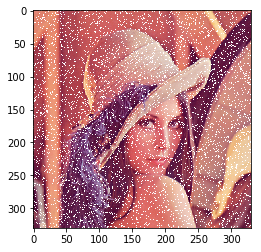

In [104]:
plt.imshow(image)

In [105]:
sample = []
for i in range(0, image.shape[0] - 10 + 1, 10):
    for j in range(0, image.shape[1] - 10 + 1, 10):
        sample.append(image[i:i+10, j:j+10, 0])
        sample.append(image[i:i+10, j:j+10, 1])
        sample.append(image[i:i+10, j:j+10, 2])
        sample.append(image[i:i+10, j:j+10, 3])

In [106]:
sample = np.array(sample).reshape(-1, 100)

In [107]:
sample.shape

(4356, 100)

In [108]:
sorted(np.linalg.norm(sample - sample[0,:], axis = 1))[20]

3.002262533867687

In [ ]:
rec_image = np.zeros_like(image)

In [ ]:
k = 0
for i in range(0, image.shape[0] - 10 + 1, 10):
    for j in range(0, image.shape[1] - 10 + 1, 10):
        rec_image[i:i+10, j:j+10, 0] = sample[k].reshape(10, 10)
        k += 1
        rec_image[i:i+10, j:j+10, 1] = sample[k].reshape(10, 10)
        k += 1
        rec_image[i:i+10, j:j+10, 2] = sample[k].reshape(10, 10)
        k += 1
        rec_image[i:i+10, j:j+10, 3] = sample[k].reshape(10, 10)

In [ ]:
plt.imshow(rec_image)